<a href="https://colab.research.google.com/github/haiton266/AI4LIFE-videomae/blob/main/examples/segformer_inference_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/segformer_inference_pretrained.ipynb)

In [1]:
# fix for HF hub download
# see PR https://github.com/albumentations-team/albumentations/pull/2171
!pip install -U git+https://github.com/qubvel/albumentations@patch-2

  Cloning https://github.com/qubvel/albumentations (to revision patch-2) to /tmp/pip-req-build-zlfyn5ec
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/albumentations /tmp/pip-req-build-zlfyn5ec
  Running command git checkout -b patch-2 --track origin/patch-2
  Switched to a new branch 'patch-2'
  Branch 'patch-2' set up to track remote branch 'patch-2' from 'origin'.
  Resolved https://github.com/qubvel/albumentations to commit 6e40b35b92f6be8d9e5ccda5312fa9dcb0383a8c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 12.8 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.21-py3-none-any.whl size=258564 sha256=379fd3ba543966bd9dc9e9eac11d093764a3eae11e90dc9ab84c8e75ae109075
  Stored in directory: /tmp/p

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-1_ikg5xs
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-1_ikg5xs
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 36c6afd95ba98b14b0794bb77d4a30560df218fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import requests
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

import torch
import segmentation_models_pytorch as smp

from PIL import Image

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# More checkpoints can be found here:
# https://huggingface.co/collections/smp-hub/segformer-6749eb4923dea2c355f29a1f
checkpoint = "smp-hub/segformer-b2-1024x1024-city-160k"

# Load pretrained model and preprocessing function
model = smp.from_pretrained(checkpoint).eval().to(device)
preprocessing = A.Compose.from_pretrained(checkpoint)

# Load image
url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess image
image = np.array(image)
normalized_image = preprocessing(image=image)["image"]
input_tensor = torch.as_tensor(normalized_image)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # HWC -> BCHW
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output_mask = model(input_tensor)

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.shape[:2], mode="bilinear", align_corners=False
)
mask = mask[0].argmax(0).cpu().numpy()

Device:  cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

albumentations_config_eval.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

In [14]:
print("normalized_image", normalized_image.shape)
print("output_mask.shape", output_mask.shape)
print("image.shape", image.shape)
print("image.shape[:2]", image.shape[:2])

normalized_image (1024, 1024, 3)
output_mask.shape torch.Size([1, 19, 1024, 1024])
image.shape (512, 683, 3)
image.shape[:2] (512, 683)


In [9]:
  mask.shape

(512, 683)

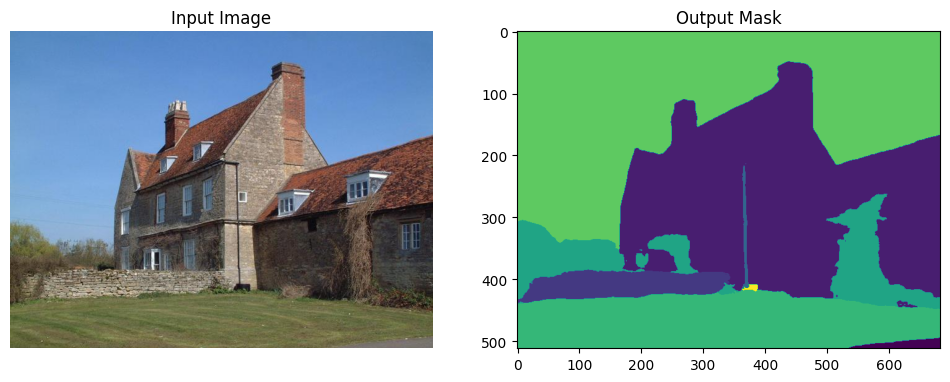

In [10]:
# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.axis("off")
plt.imshow(image)
plt.title("Input Image")

plt.subplot(122)
# plt.axis("off")
plt.imshow(mask)
plt.title("Output Mask")

plt.show()